In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders.binary import BinaryEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.keys]

In [3]:
class TypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, type_features):
        self.type_features = type_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.type_features == 'cat':
            return X.astype('bool')
        elif self.type_features == 'bin':
            return X.astype('bool')

In [4]:
class ArrayToDF(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

In [5]:
class Union(BaseEstimator, TransformerMixin):
    def __init__(self, transformers:list):
        self.transformers = transformers
    
    def fit(self, X, y=None):
        for transformer in self.transformers:
            transformer.fit(X)
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        for transformer in self.transformers:
            df = pd.concat((df, transformer.transform(X)), axis=1)
        return df

In [6]:
df = pd.read_csv('data.csv')
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [7]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df['treatment'].replace(to_replace=['Buy One Get One', 'Discount', 'No Offer'], value=[1, 1, 0], inplace=True)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [8]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df.drop(['target', 'treatment'], axis=1), 
                                                                             df['target'], df['treatment'])

In [9]:
cat_features = ['zip_code', 'channel']
bin_features = ['used_discount', 'used_bogo', 'is_referral']
other_features = list(set(X_train.columns) - set(cat_features) - set(bin_features))

In [10]:
cat_transformer = Pipeline([('selector', ColumnSelector(cat_features)), 
          ('ecoder', BinaryEncoder()), 
          ('type_transformer', TypeTransformer('cat'))])

bin_transformer = Pipeline([('selector', ColumnSelector(bin_features)), 
          ('type_transformer', TypeTransformer('bin'))])

other_transformer = Pipeline([('selector', ColumnSelector(other_features))])

In [11]:
transformer =  Union([cat_transformer, bin_transformer, other_transformer]).fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [12]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

In [13]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=sm.predict(X_test), treatment=treat_test, strategy='by_group', k=0.1)

In [14]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=sm.predict(X_test), treatment=treat_test, strategy='by_group', k=0.2)

In [15]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

In [16]:
ct_score_10 = uplift_at_k(y_true=y_test, uplift=ct.predict(X_test), treatment=treat_test, strategy='by_group', k=0.1)

In [17]:
ct_score_20 = uplift_at_k(y_true=y_test, uplift=ct.predict(X_test), treatment=treat_test, strategy='by_group', k=0.2)

In [18]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

In [19]:
tm_score_10 = uplift_at_k(y_true=y_test, uplift=tm.predict(X_test), treatment=treat_test, strategy='by_group', k=0.1)

In [20]:
tm_score_20 = uplift_at_k(y_true=y_test, uplift=tm.predict(X_test), treatment=treat_test, strategy='by_group', k=0.2)

In [21]:
pd.DataFrame({'solo_model': [sm_score_10, sm_score_20],
             'class_transformation': [ct_score_10, ct_score_20],
             'two_models': [tm_score_10, tm_score_20]}, index=['uplift@10%', 'uplift@20%'])

,solo_model,class_transformation,two_models
uplift@10%,0.088190,0.093649,0.113449
uplift@20%,0.075907,0.089922,0.066531


In [22]:
X_dec = pd.concat((X_test, y_test), axis=1)
X_dec['sm_predict'] = sm.predict(X_test)

In [23]:
X_dec

,zip_code_0,zip_code_1,channel_0,channel_1,used_discount,used_bogo,is_referral,history,recency,target,sm_predict
22631,True,True,True,True,False,True,True,689.53,5,0,0.085994
38822,True,False,False,True,True,False,False,365.64,7,0,0.075201
35957,False,True,False,True,True,False,False,275.09,2,0,0.054875
40560,False,True,True,False,True,False,False,29.99,11,0,0.020805
63126,True,True,False,True,False,True,True,304.92,12,0,0.025902
...,...,...,...,...,...,...,...,...,...,...,...
44995,True,False,False,True,True,False,False,29.99,4,0,0.055132
63678,False,True,False,True,False,True,True,34.59,9,0,0.045567
10835,True,False,False,True,False,True,False,29.99,2,0,0.076231
60569,False,True,True,False,True,False,False,240.33,10,0,0.042187


In [24]:
X_dec['deciles'] = pd.qcut(X_dec['sm_predict'], 10, labels=False)
X_dec

,zip_code_0,zip_code_1,channel_0,channel_1,used_discount,used_bogo,is_referral,history,recency,target,sm_predict,deciles
22631,True,True,True,True,False,True,True,689.53,5,0,0.085994,8
38822,True,False,False,True,True,False,False,365.64,7,0,0.075201,6
35957,False,True,False,True,True,False,False,275.09,2,0,0.054875,4
40560,False,True,True,False,True,False,False,29.99,11,0,0.020805,0
63126,True,True,False,True,False,True,True,304.92,12,0,0.025902,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44995,True,False,False,True,True,False,False,29.99,4,0,0.055132,4
63678,False,True,False,True,False,True,True,34.59,9,0,0.045567,3
10835,True,False,False,True,False,True,False,29.99,2,0,0.076231,7
60569,False,True,True,False,True,False,False,240.33,10,0,0.042187,2


In [25]:
target_uplift = X_dec.groupby('deciles')[['target', 'sm_predict']].mean()
target_uplift

,target,sm_predict
deciles,,
0,0.093125,0.021893
1,0.116105,0.033257
2,0.116875,0.041663
3,0.125782,0.047701
4,0.146235,0.054327
5,0.159448,0.061928
6,0.146067,0.070742
7,0.167497,0.079743
8,0.185302,0.091057


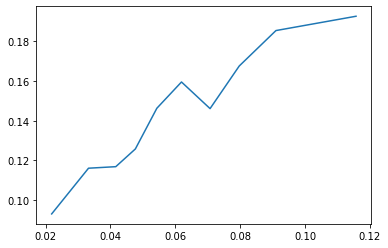

In [26]:
plt.plot(target_uplift['sm_predict'], target_uplift['target'])
plt.show()